### Import Libraries

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

### Data Loading and Transformation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100.0%


In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 100, shuffle  = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 100, shuffle  = False)

### Define the model

In [10]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.max_pool2d = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features = 16*5*5, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)
        self.fc3 = nn.Linear(in_features = 84, out_features = 10)

    def forward(self, x):
        x = self.conv1(x) # Apply first convolution
        x = self.relu(x) # Apply ReLU activation
        x = self.max_pool2d(x)  # Apply max pooling
        x = self.conv2(x) # Apply second convolution
        x = self.relu(x) # Apply ReLU activation
        x = self.max_pool2d(x) # Apply max pooling
        x = x.view(-1, self.flattened_features(x)) # Flatten the output for the fully connected layers
        x = self.relu(self.fc1(x)) # Apply first fully connected layer with ReLU activation
        x = self.relu(self.fc2(x)) # Apply second fully connected layer with ReLU activation
        x = self.fc3(x) # Output layer (raw logits)
        return x
    
    def flattened_features(self, x):
        size = x.size()[1:] # Extract spatial dimensions
        num_features = 1
        for s in size:
            num_features *= s # Compute the flattened feature size
        return num_features


### Model Initialization

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

In [16]:
print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

### Define Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Train the Model

In [18]:
def train_model(model, train_loader, criterion, optimizer, epochs = 10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move data to the correct device

            optimizer.zero_grad() # Zero out previous gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward() # Backpropagation
            optimizer.step() # Update model weights

            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print('Training Complete')

In [20]:
train_model(model, train_loader, criterion, optimizer, epochs = 25)

Epoch [1/25], Loss: 0.9278
Epoch [2/25], Loss: 0.9025
Epoch [3/25], Loss: 0.8771
Epoch [4/25], Loss: 0.8577
Epoch [5/25], Loss: 0.8385
Epoch [6/25], Loss: 0.8174
Epoch [7/25], Loss: 0.8028
Epoch [8/25], Loss: 0.7825
Epoch [9/25], Loss: 0.7660
Epoch [10/25], Loss: 0.7485
Epoch [11/25], Loss: 0.7306
Epoch [12/25], Loss: 0.7193
Epoch [13/25], Loss: 0.7071
Epoch [14/25], Loss: 0.6868
Epoch [15/25], Loss: 0.6745
Epoch [16/25], Loss: 0.6630
Epoch [17/25], Loss: 0.6524
Epoch [18/25], Loss: 0.6341
Epoch [19/25], Loss: 0.6302
Epoch [20/25], Loss: 0.6148
Epoch [21/25], Loss: 0.6033
Epoch [22/25], Loss: 0.5955
Epoch [23/25], Loss: 0.5797
Epoch [24/25], Loss: 0.5742
Epoch [25/25], Loss: 0.5622
Training Complete


### Evaluate the Model

In [21]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculations for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) # Get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [22]:
evaluate_model(model, test_loader)

Accuracy: 63.44%


### Visualize Predictions

In [23]:
def visualize_pred(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(5):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].set_title(f'Actual: {labels[i]}, Predicted: {predicted[i]}')
        axes[i].axis('off')
    plt.show()

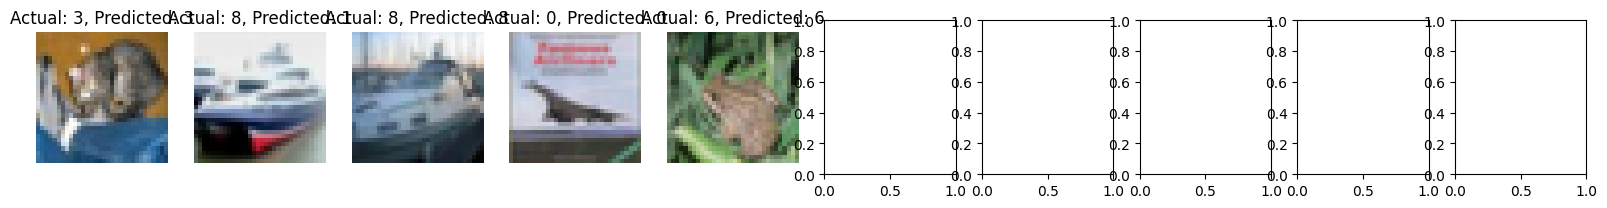

In [24]:
visualize_pred(model, test_loader)

In [28]:
# Evaluate class-wise accuracy

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))


with torch.no_grad():
    for data in test_loader:
        im, ground_truth = data
        op = model(im)  # Forward pass
        _, pred = torch.max(op, 1)  # Get predictions
        c = (pred == ground_truth).squeeze()  # Compare predictions with ground truth
        for i in range(len(ground_truth)):
            ground_truth_curr = ground_truth[i].item()
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

# Print accuracy for each class
for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 68 %
Model accuracy for class   car : 73 %
Model accuracy for class  bird : 58 %
Model accuracy for class   cat : 38 %
Model accuracy for class  deer : 59 %
Model accuracy for class   dog : 51 %
Model accuracy for class  frog : 67 %
Model accuracy for class horse : 68 %
Model accuracy for class  ship : 76 %
Model accuracy for class truck : 74 %
